In [1]:
import tensorflow as tf
from tensorflow.keras.datasets.reuters import load_data
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import pandas as pd
import itertools

In [2]:
SEED = 12345
tf.random.set_seed(SEED)

## Data

### Loading

In [3]:
(X, y), (_, _) = load_data(test_split=0.0)

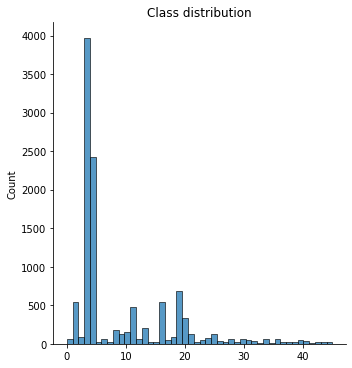

In [4]:
sns.displot(y)
plt.title('Class distribution')
plt.show()

### Top frequent classes

Due to data inbalance we take only top 10 most frequent classes.

In [5]:
unique, counts = np.unique(y, return_counts=True)
classes = dict(zip(unique, counts))
sorted_classes = [
  x[0] for x in sorted(classes.items(),
                       key=lambda item: item[1],
                       reverse=True)
  ]
top_10_classes = sorted_classes[0:10]

In [6]:
top_10_classes

[3, 4, 19, 16, 1, 11, 20, 13, 8, 10]

In [7]:
sorted(classes.items(),
  key=lambda item: item[1],
  reverse=True
)[0:10]

[(3, 3972),
 (4, 2423),
 (19, 682),
 (16, 543),
 (1, 537),
 (11, 473),
 (20, 339),
 (13, 209),
 (8, 177),
 (10, 154)]

In [8]:
recoded_dict = {}

i = 0
for c in top_10_classes:
  recoded_dict[c] = i
  i += 1

In [9]:
topics = ['cocoa','grain','veg-oil','earn','acq','wheat','copper','housing','money-supply',
   'coffee','sugar','trade','reserves','ship','cotton','carcass','crude','nat-gas',
   'cpi','money-fx','interest','gnp','meal-feed','alum','oilseed','gold','tin',
   'strategic-metal','livestock','retail','ipi','iron-steel','rubber','heat','jobs',
   'lei','bop','zinc','orange','pet-chem','dlr','gas','silver','wpi','hog','lead']

classes_dict = {}
for c in top_10_classes:
  classes_dict[recoded_dict[c]] = topics[c]

classes_dict

{0: 'earn',
 1: 'acq',
 2: 'money-fx',
 3: 'crude',
 4: 'grain',
 5: 'trade',
 6: 'interest',
 7: 'ship',
 8: 'money-supply',
 9: 'sugar'}

### Data generator

Function to generate daset for N most frequent words.

In [10]:
def get_datasets(num_words, input_size):

  (X, y), (_, _) = load_data(num_words=num_words, test_split=0.0)

  X = X[np.isin(y, top_10_classes)]
  y = y[np.isin(y, top_10_classes)]
  
  y = np.array([recoded_dict[k] for k in y])

  #padding
  X = np.array([
    np.pad(
        x, (input_size-len(x), 0)
    ) if input_size > len(x) else np.array(x[0:input_size]) for x in X
  ])
  # X = tf.convert_to_tensor(X)

  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.4, random_state=SEED
  )
  X_val, X_test, y_val, y_test = train_test_split(
      X_test, y_test, test_size=0.5, random_state=SEED
  )

  train_data = {
      'X': X_train,
      'y': y_train
  }
  val_data = {
      'X': X_val,
      'y': y_val
  }
  test_data = {
      'X': X_test,
      'y': y_test
  }

  return train_data, val_data, test_data

In [11]:
a = np.array([1,2,3])

In [12]:
np.pad(a, (2, 0))

array([0, 0, 1, 2, 3])

## Helper functions

In [13]:
def print_results(model):
  print('--------MODEL--------')
  print()
  print(model.name)
  # print()
  # print(model.model.summary())
  print()
  # print('Optimizer: ', model.params['optimizer'])
  # print('Learning rate: ', model.params['lr'])
  # print('Epochs: ', model.params['epochs'])
  # print('Batch: ', model.params['batch'])
  print('Num words: ', model.params['num_words'])
  print()
  print('Best validation Loss: ', max(model.history.history['val_loss']))
  print('Best validation Accuracy: ', max(model.history.history['val_accuracy']))
  print('Best validation F1Score: ', max(model.history.history['val_f1score']))
  print()


def plot_history(history):
  history = history.history

  epochs = [i+1 for i in range(len(history['loss']))]
  fig, axs = plt.subplots(1, 3, figsize=(20,5))
  axs[0].plot(epochs, history['loss'], label='TRAIN')
  axs[0].plot(epochs, history['val_loss'], label='VALIDATION')
  axs[0].legend()
  axs[0].title.set_text('LOSS')
  axs[0].set_xlabel('EPOCH')
  axs[0].set_ylabel('VALUE')
  axs[1].plot(epochs, history['f1score'], label='TRAIN')
  axs[1].plot(epochs, history['val_f1score'], label='VALIDATION')
  axs[1].legend()
  axs[1].title.set_text('F1 SCORE')
  axs[1].set_xlabel('EPOCH')
  axs[1].set_ylabel('VALUE')
  axs[2].plot(epochs, history['accuracy'], label='TRAIN')
  axs[2].plot(epochs, history['val_accuracy'], label='VALIDATION')
  axs[2].legend()
  axs[2].title.set_text('ACCURACY')
  axs[2].set_xlabel('EPOCH')
  axs[2].set_ylabel('VALUE')
  plt.show()
  

def show_results(model):
  print_results(model)
  plot_history(model.history)
  print()


def get_misclasified(c):
    return [i for i in range(len(y_true.numpy()))
                 if y_true.numpy()[i] != y_pred.numpy()[i] and y_true.numpy()[i] == c]


def get_properclasified(c):
    return [i for i in range(len(y_true.numpy()))
                 if y_true.numpy()[i] == y_pred.numpy()[i] and y_true.numpy()[i] == c]


def plot_misclasified(c):
    fig, axs = plt.subplots(1, 3, figsize=(20,5))
    axs[0].imshow(test_ds['X'][get_misclasified(c)[0]])
    axs[0].title.set_text('TRUE: '+class_name[c]+' | PREDICTED: '+class_name[y_pred[get_misclasified(c)[0]].numpy()])
    axs[1].imshow(test_ds['X'][get_misclasified(c)[1]])
    axs[1].title.set_text('TRUE: '+class_name[c]+' | PREDICTED: '+class_name[y_pred[get_misclasified(c)[1]].numpy()])
    axs[2].imshow(test_ds['X'][get_misclasified(c)[2]])
    axs[2].title.set_text('TRUE: '+class_name[c]+' | PREDICTED: '+class_name[y_pred[get_misclasified(c)[2]].numpy()])
    plt.show()
    

def plot_properclasified(c):
    fig, axs = plt.subplots(1, 3, figsize=(20,5))
    axs[0].imshow(test_ds['X'][get_properclasified(c)[0]])
    axs[0].title.set_text('TRUE: '+class_name[c]+' | PREDICTED: '+class_name[y_pred[get_properclasified(c)[0]].numpy()])
    axs[1].imshow(test_ds['X'][get_properclasified(c)[1]])
    axs[1].title.set_text('TRUE: '+class_name[c]+' | PREDICTED: '+class_name[y_pred[get_properclasified(c)[1]].numpy()])
    axs[2].imshow(test_ds['X'][get_properclasified(c)[2]])
    axs[2].title.set_text('TRUE: '+class_name[c]+' | PREDICTED: '+class_name[y_pred[get_properclasified(c)[2]].numpy()])
    plt.show()

def test_model(model):

    show_results(model)

    model = model.model

    print()
    y_true = tf.reshape(test_ds['y'], test_ds['y'].shape[0])
    y_pred_probs = model.predict(test_ds['X'])
    print('Test F1: '+str(f1score(y_true, y_pred_probs)))

    print()
    print(metrics_summary(y_true, y_pred_probs))

    print()

    y_pred = tf.math.argmax(y_pred_probs, 1)
    y_pred = tf.reshape(y_pred, y_pred.shape[0])

    labels = tf.unique(y_true)[0].numpy()
    labels.sort()

    matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(matrix, index = labels,
                      columns = [i for i in labels])

    plt.figure(figsize = (10,7))
    plt.title("Confusion matrix")
    sns.heatmap(df_cm, annot=True, fmt='g')
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show()


## Custom metrics

In [14]:
def f1score(y_true, y_pred):
    y_true = tf.reshape(y_true, y_true.shape[0])
    y_pred = tf.math.argmax(y_pred, 1)
    y_pred = tf.reshape(y_pred, y_pred.shape[0])
    return f1_score(y_true, y_pred, average='macro')

def metrics_summary(y_true, y_pred):
    y_true = tf.reshape(y_true, y_true.shape[0])
    y_pred = tf.math.argmax(y_pred, 1)
    y_pred = tf.reshape(y_pred, y_pred.shape[0])
    return classification_report(y_true, y_pred, target_names=classes_dict.values())    

## Custom layers


### Embedding

In [15]:
class Embedding(tf.keras.layers.Layer):

  def __init__(self, num_words, emb_size):

    super(Embedding, self).__init__()
    self.num_words = num_words
    self.emb_size = emb_size

    self.emb_matrix = self.add_weight(
        shape=([self.num_words, self.emb_size]),
        initializer='random_normal',
        trainable=True
    )

  def __call__(self, words_ids):

    return tf.nn.embedding_lookup(self.emb_matrix, words_ids)

### RNN

In [16]:
class RNN(tf.keras.layers.Layer):

  def __init__(self, state_size, input_size, output_size):

    super(RNN, self).__init__()
    self.state_size = state_size
    self.input_size = input_size
    self.output_size = output_size

    self.W_pred = self.add_weight(
        shape=([self.state_size, self.output_size]),
        initializer='random_uniform',
        trainable=True
    )
    self.b_pred = self.add_weight(
        shape=([self.output_size]),
        initializer='random_uniform',
        trainable=True
    )

    self.W_h = self.add_weight(
        shape=([self.state_size, self.state_size]),
        initializer='random_uniform',
        trainable=True
    )
    self.W_x = self.add_weight(
        shape=([self.input_size, self.state_size]),
        initializer='random_uniform',
        trainable=True
    )
    self.b = self.add_weight(
        shape=([self.state_size]),
        initializer='random_uniform',
        trainable=True
    )

  def call(self, x):

    x = tf.transpose(x, perm=[1, 0, 2])

    initial_state = tf.zeros(
      [x.shape[1], self.state_size],
      name='initial_state'
    )
    states = tf.scan(
      self._rnn_step, x,
      initializer=initial_state,
      name='states'
    )

    predictions = tf.add(
        tf.matmul(states, self.W_pred),
        self.b_pred,
        name='predictions'
    )
        
    return states, predictions

  def _rnn_step(self, h_prev, x):

    h = tf.tanh(
      tf.matmul(h_prev, self.W_h) + tf.matmul(x, self.W_x) + self.b
    )

    return h

### LSTM

In [17]:
class LSTM(tf.keras.layers.Layer):

  def __init__(self, state_size, input_size, output_size):

    super(LSTM, self).__init__()
    self.state_size = state_size
    self.input_size = input_size
    self.output_size = output_size

    self.W_f = self.add_weight(
        shape=([self.state_size + self.input_size, self.state_size]),
        initializer='random_uniform',
        trainable=True
    )
    self.b_f = self.add_weight(
        shape=([1, self.state_size]),
        initializer='random_uniform',
        trainable=True
    )

    self.W_i = self.add_weight(
        shape=([self.state_size + self.input_size, self.state_size]),
        initializer='random_uniform',
        trainable=True
    )
    self.b_i = self.add_weight(
        shape=([1, self.state_size]),
        initializer='random_uniform',
        trainable=True
    )

    self.W_C = self.add_weight(
        shape=([self.state_size + self.input_size, self.state_size]),
        initializer='random_uniform',
        trainable=True
    )
    self.b_C = self.add_weight(
        shape=([1, self.state_size]),
        initializer='random_uniform',
        trainable=True
    )

    self.W_o = self.add_weight(
        shape=([self.state_size + self.input_size, self.state_size]),
        initializer='random_uniform',
        trainable=True
    )
    self.b_o = self.add_weight(
        shape=([1, self.state_size]),
        initializer='random_uniform',
        trainable=True
    )

    self.W_v = self.add_weight(
        shape=([self.state_size, self.output_size]),
        initializer='random_uniform',
        trainable=True
    )
    self.b_v = self.add_weight(
        shape=([1, self.output_size]),
        initializer='random_uniform',
        trainable=True
    )

  def call(self, x):

    x = tf.transpose(x, perm=[1, 0, 2])

    initial_h_state = tf.zeros(
      [x.shape[1], self.state_size]
    )
    initial_C_state = tf.zeros(
      [x.shape[1], self.state_size]
    )
    initial_state = (initial_h_state, initial_C_state)

    states = tf.scan(
      self._lstm_step, x,
      initializer=initial_state,
      name='states'
    )

    # h_states = tf.transpose(states[1], perm=[1, 0, 2])
    h_states = states[1]

    predictions = tf.add(
        tf.matmul(h_states, self.W_v),
        self.b_v,
        name='predictions'
    )
        
    return states, predictions

  def _lstm_step(self, prev_result, x):

    (C_state_prev, h_state_prev) = prev_result

    # forget gate

    f_t = tf.sigmoid(
        tf.add(
            tf.matmul(tf.concat((h_state_prev, x), axis = 1), self.W_f),
            self.b_f
        )
    )

    # input gate

    i_t = tf.sigmoid(
        tf.add(
            tf.matmul(tf.concat((h_state_prev, x), axis = 1), self.W_i),
            self.b_i
        )
    )

    cC_state = tf.tanh(
        tf.add(
            tf.matmul(tf.concat((h_state_prev, x), axis = 1), self.W_C),
            self.b_C
        )
    )

    # update C state

    C_state = tf.add(
        f_t * C_state_prev,
        i_t * cC_state
    )

    # update h state

    o_t = tf.sigmoid(
        tf.add(
            tf.matmul(tf.concat((h_state_prev, x), axis = 1), self.W_o),
            self.b_o
        )
    )

    h_state = o_t * tf.tanh(C_state)

    return (C_state, h_state)

## Models

In [18]:
class RNNModel(tf.keras.Model):

  def __init__(
      self,
      num_words,
      embedding_size,
      state_size,
      output_size):
    super(RNNModel, self).__init__()
    self.embedding = Embedding(num_words, embedding_size)
    self.rnn = RNN(state_size, embedding_size, output_size)
    self.act = tf.keras.activations.softmax


  def call(self, inputs, training=False):
    X = self.embedding(inputs)
    X = self.rnn(X)[1][-1]
    X = self.act(X)

    return X


class LSTMModel(tf.keras.Model):

  def __init__(
      self,
      num_words,
      embedding_size,
      state_size,
      output_size):
    super(LSTMModel, self).__init__()
    self.embedding = Embedding(num_words, embedding_size)
    self.lstm = LSTM(state_size, embedding_size, output_size)
    self.act = tf.keras.activations.softmax


  def call(self, inputs, training=False):
    X = self.embedding(inputs)
    X = self.lstm(X)[1][-1]
    X = self.act(X)

    return X

In [19]:
class Model1:
  def __init__(
      self,
      num_words,
      embedding_size,
      state_size,
      output_size=10):

    self.model = RNNModel(
      num_words=num_words,
      embedding_size=embedding_size,
      state_size=state_size,
      output_size=output_size
    )

    self.name = 'Model1_RNN'
    self.history = None
    self.params = None
    self.test_ds = None

  
class Model2:
  def __init__(
      self,
      num_words,
      embedding_size,
      state_size,
      output_size=10):

    self.model = LSTMModel(
      num_words=num_words,
      embedding_size=embedding_size,
      state_size=state_size,
      output_size=output_size
    )

    self.name = 'Model2_LSTM'
    self.history = None
    self.params = None
    self.test_ds = None

## Training

In [20]:
params = {
    'model': [Model1, Model2],
    'num_words': [250, 500, 1000, 2000],
    'input_size': [100],
    'embedding_size': [32],
    'state_size': [64],
    'optimizer': ['adam'],
    'lr': [0.001],
    'epochs': [100],
    'batch': [500]
}

results = pd.DataFrame(columns=[
                                'model', 'num_words', 'input_size',
                                'embedding_size', 'state_size', 'optimizer',
                                'lr', 'epochs', 'batch',
                                'best_val_loss', 'best_val_acc', 'best_val_f1'
])
trained_models = []

keys = list(params)
for values in itertools.product(*map(params.get, keys)):
  params_dict = dict(zip(keys, values))

  tf.keras.backend.clear_session()

  if params_dict['optimizer'] == 'adam':
    opt = tf.keras.optimizers.Adam(params_dict['lr'])
  else: 
    opt = tf.keras.optimizers.SGD(params_dict['lr'])

  model = params_dict['model'](
      num_words=params_dict['num_words'],
      embedding_size=params_dict['embedding_size'],
      state_size=params_dict['state_size']
  )

  model.model.compile(optimizer=opt,
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy', f1score], run_eagerly=True)
  
  train_ds, val_ds, test_ds = get_datasets(
      params_dict['num_words'],
      params_dict['input_size']
  )

  history = model.model.fit(train_ds['X'], train_ds['y'],
                      batch_size=params_dict['batch'],
                      epochs=params_dict['epochs'], 
                      validation_data=(val_ds['X'], val_ds['y']))

  model.test_ds = test_ds
  model.params = params_dict
  model.history = history
  trained_models.append(model)
  results = results.append({
      'model': model.name,
      'num_words': params_dict['num_words'],
      'input_size': params_dict['input_size'],
      'embedding_size': params_dict['embedding_size'],
      'state_size': params_dict['state_size'],
      'optimizer': params_dict['optimizer'],
      'lr': params_dict['lr'],
      'epochs': params_dict['epochs'],
      'batch': params_dict['batch'],
      'best_val_loss': max(history.history['val_loss']),
      'best_val_acc': max(history.history['val_accuracy']),
      'best_val_f1': max(history.history['val_f1score'])
  }, ignore_index=True)

results = results.reset_index(inplace=False)

Epoch 1/100
12/12 [==============================] - 2s 159ms/step - loss: 2.2647 - accuracy: 0.3194 - f1score: 0.0461 - val_loss: 2.2196 - val_accuracy: 0.4117 - val_f1score: 0.0584
Epoch 2/100
12/12 [==============================] - 2s 147ms/step - loss: 2.0822 - accuracy: 0.4168 - f1score: 0.0590 - val_loss: 1.7550 - val_accuracy: 0.4117 - val_f1score: 0.0584
Epoch 3/100
12/12 [==============================] - 2s 151ms/step - loss: 1.7696 - accuracy: 0.4168 - f1score: 0.0591 - val_loss: 1.7116 - val_accuracy: 0.4117 - val_f1score: 0.0584
Epoch 4/100
12/12 [==============================] - 2s 149ms/step - loss: 1.7294 - accuracy: 0.4168 - f1score: 0.0588 - val_loss: 1.7031 - val_accuracy: 0.4117 - val_f1score: 0.0584
Epoch 5/100
12/12 [==============================] - 2s 146ms/step - loss: 1.7246 - accuracy: 0.4168 - f1score: 0.0595 - val_loss: 1.6891 - val_accuracy: 0.4117 - val_f1score: 0.0584
Epoch 6/100
12/12 [==============================] - 2s 148ms/step - loss: 1.7166 - a

In [21]:
results.sort_values('best_val_f1', ascending=False)

,index,model,num_words,input_size,embedding_size,state_size,optimizer,lr,epochs,batch,best_val_loss,best_val_acc,best_val_f1
6,6,Model2_LSTM,1000,100,32,64,adam,0.001,100,500,2.285933,0.697687,0.274395
2,2,Model1_RNN,1000,100,32,64,adam,0.001,100,500,2.217672,0.651420,0.255895
4,4,Model2_LSTM,250,100,32,64,adam,0.001,100,500,2.286945,0.690852,0.250072
3,3,Model1_RNN,2000,100,32,64,adam,0.001,100,500,2.259909,0.667192,0.242333
7,7,Model2_LSTM,2000,100,32,64,adam,0.001,100,500,2.267496,0.682440,0.236533
1,1,Model1_RNN,500,100,32,64,adam,0.001,100,500,2.203737,0.657203,0.232633
5,5,Model2_LSTM,500,100,32,64,adam,0.001,100,500,2.246664,0.679811,0.213631
0,0,Model1_RNN,250,100,32,64,adam,0.001,100,500,2.219576,0.645110,0.208049


--------MODEL--------

Model1_RNN

Num words:  250

Best validation Loss:  2.2195756435394287
Best validation Accuracy:  0.6451104283332825
Best validation F1Score:  0.20804888010025024



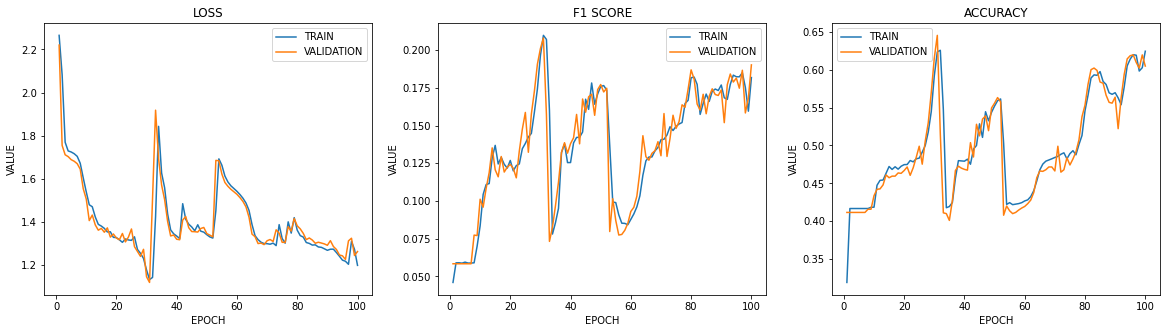


--------MODEL--------

Model1_RNN

Num words:  500

Best validation Loss:  2.203737258911133
Best validation Accuracy:  0.657202959060669
Best validation F1Score:  0.23263263702392578



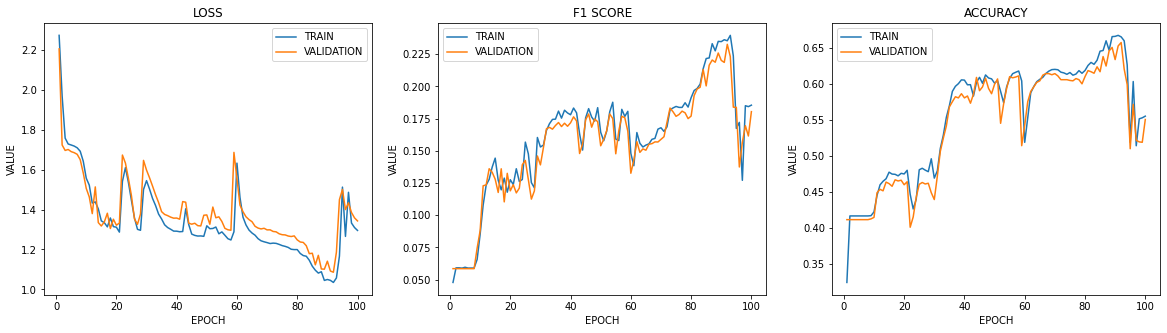


--------MODEL--------

Model1_RNN

Num words:  1000

Best validation Loss:  2.217672348022461
Best validation Accuracy:  0.6514195799827576
Best validation F1Score:  0.2558949589729309



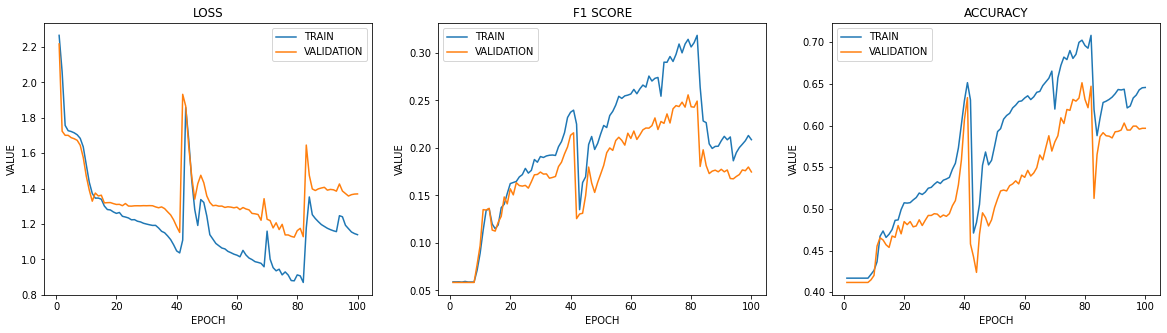


--------MODEL--------

Model1_RNN

Num words:  2000

Best validation Loss:  2.259909152984619
Best validation Accuracy:  0.6671923995018005
Best validation F1Score:  0.24233263731002808



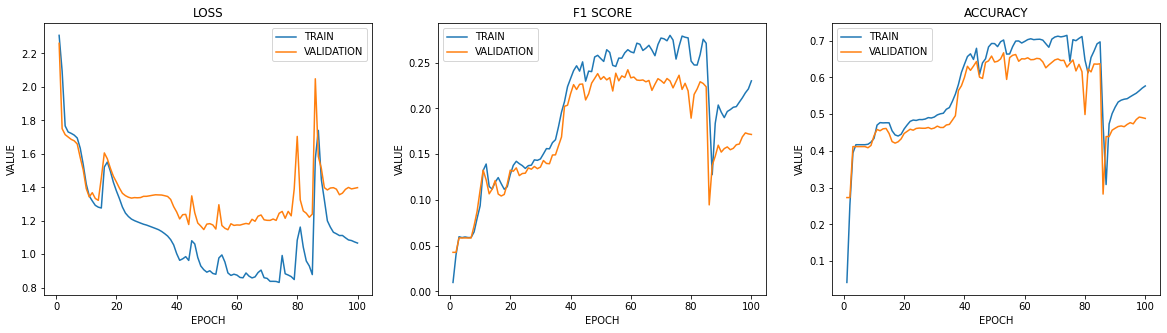


--------MODEL--------

Model2_LSTM

Num words:  250

Best validation Loss:  2.286945104598999
Best validation Accuracy:  0.6908517479896545
Best validation F1Score:  0.25007200241088867



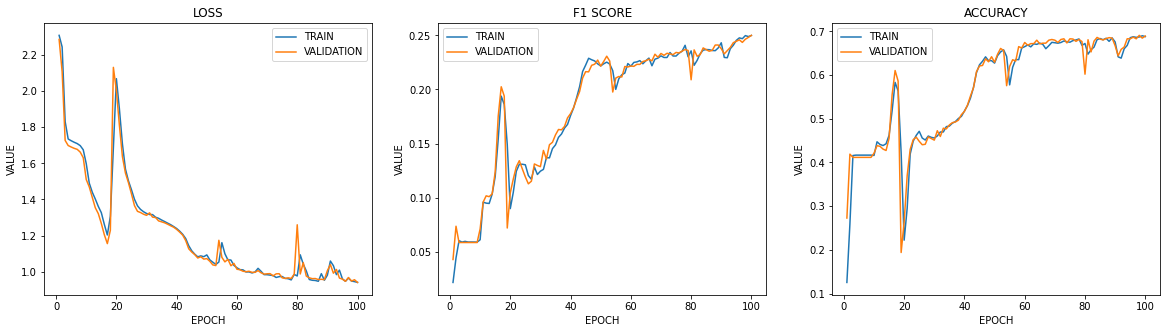


--------MODEL--------

Model2_LSTM

Num words:  500

Best validation Loss:  2.246663808822632
Best validation Accuracy:  0.6798107028007507
Best validation F1Score:  0.2136305421590805



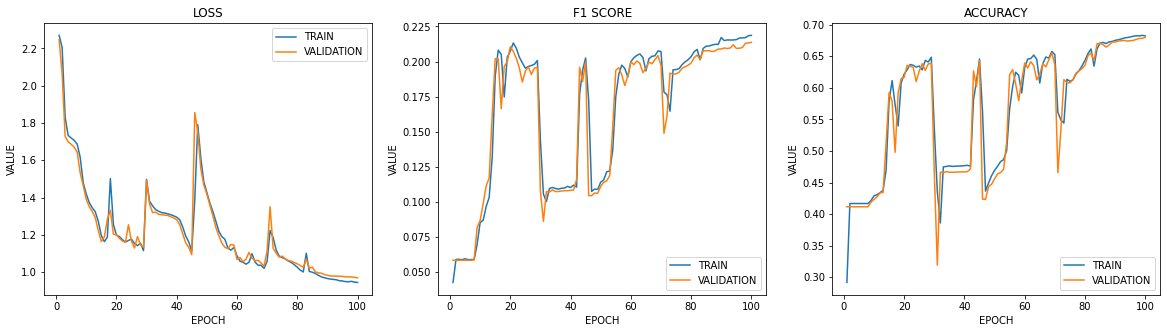


--------MODEL--------

Model2_LSTM

Num words:  1000

Best validation Loss:  2.2859325408935547
Best validation Accuracy:  0.6976866722106934
Best validation F1Score:  0.2743948698043823



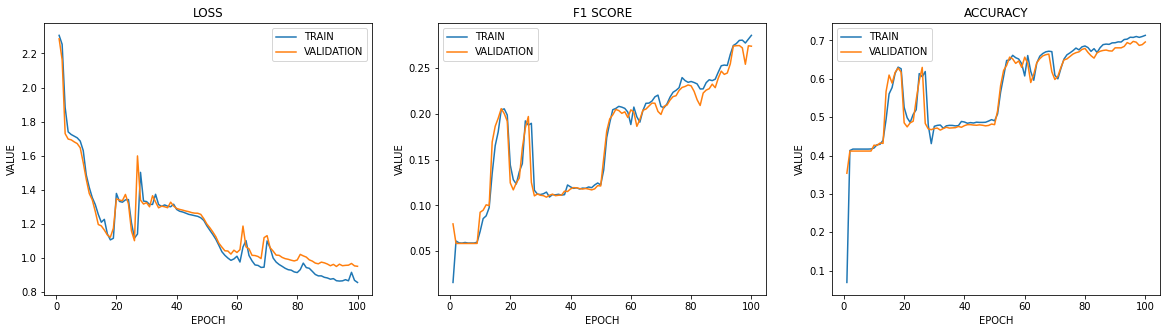


--------MODEL--------

Model2_LSTM

Num words:  2000

Best validation Loss:  2.26749587059021
Best validation Accuracy:  0.6824395656585693
Best validation F1Score:  0.23653322458267212



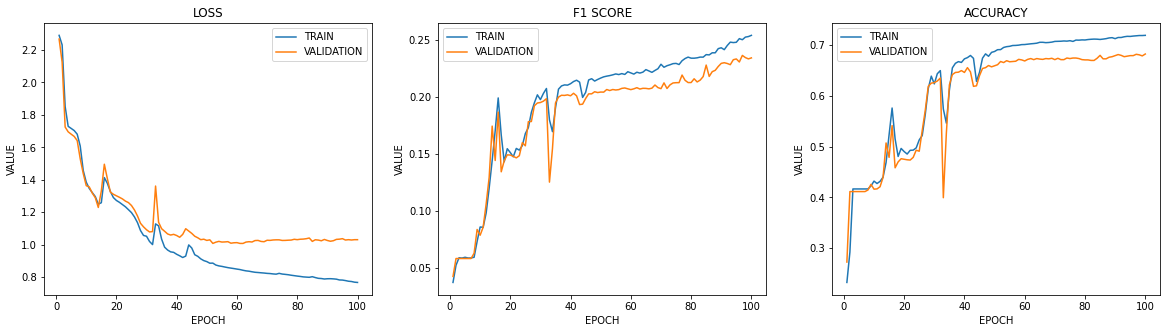

In [22]:
for model in trained_models:
  show_results(model)

## Best models

### Best RNN

In [23]:
model = trained_models[
  results[results['model'] == 'Model1_RNN']
    .sort_values('best_val_f1', ascending=False)
    .iloc[0]['index']
  ]

--------MODEL--------

Model1_RNN

Num words:  1000

Best validation Loss:  2.217672348022461
Best validation Accuracy:  0.6514195799827576
Best validation F1Score:  0.2558949589729309



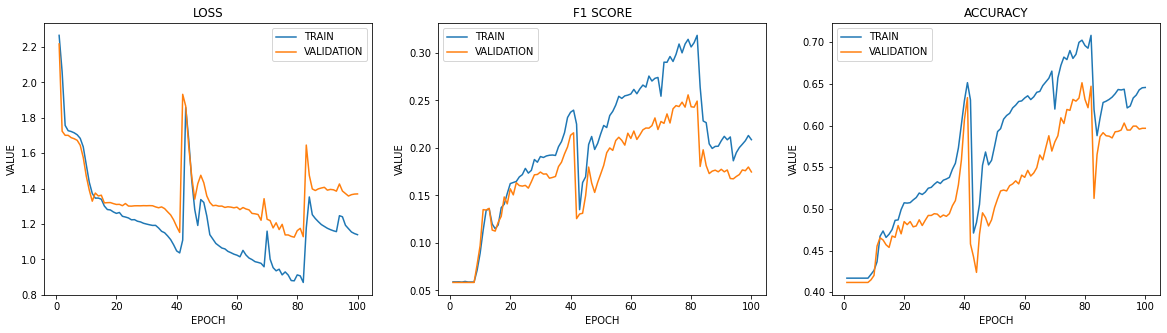

In [24]:
show_results(model)

In [25]:
model = model.model

In [26]:
y_true = tf.reshape(test_ds['y'], test_ds['y'].shape[0])
y_pred_probs = model.predict(test_ds['X'])
print('Test F1: '+str(f1score(y_true, y_pred_probs)))

Test F1: 0.1621969799582313


In [27]:
print(metrics_summary(y_true, y_pred_probs))

              precision    recall  f1-score   support

        earn       0.84      0.92      0.88       811
         acq       0.42      0.72      0.53       460
    money-fx       0.10      0.12      0.11       139
       crude       0.00      0.00      0.00       119
       grain       0.00      0.00      0.00        98
       trade       0.12      0.05      0.08        92
    interest       0.08      0.01      0.02        72
        ship       0.00      0.00      0.00        43
money-supply       0.00      0.00      0.00        40
       sugar       0.00      0.00      0.00        28

    accuracy                           0.58      1902
   macro avg       0.16      0.18      0.16      1902
weighted avg       0.48      0.58      0.52      1902



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


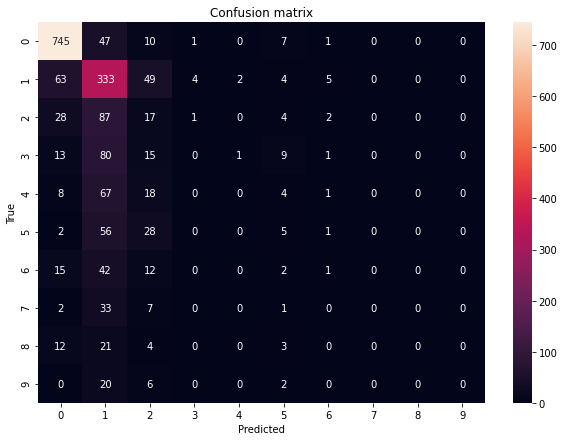

In [28]:
y_pred = tf.math.argmax(y_pred_probs, 1)
y_pred = tf.reshape(y_pred, y_pred.shape[0])

labels = tf.unique(y_true)[0].numpy()
labels.sort()

matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(matrix, index = labels,
                  columns = [i for i in labels])

plt.figure(figsize = (10,7))
plt.title("Confusion matrix")
sns.heatmap(df_cm, annot=True, fmt='g')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

### Best LSTM

In [29]:
model = trained_models[
  results[results['model'] == 'Model2_LSTM']
    .sort_values('best_val_f1', ascending=False)
    .iloc[0]['index']
  ]

--------MODEL--------

Model2_LSTM

Num words:  1000

Best validation Loss:  2.2859325408935547
Best validation Accuracy:  0.6976866722106934
Best validation F1Score:  0.2743948698043823



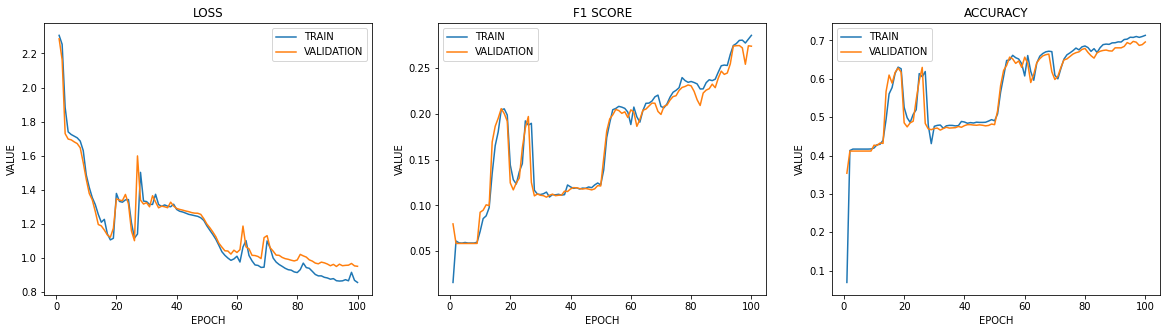

In [30]:
show_results(model)

In [31]:
model = model.model

In [32]:
y_true = tf.reshape(test_ds['y'], test_ds['y'].shape[0])
y_pred_probs = model.predict(test_ds['X'])
print('Test F1: '+str(f1score(y_true, y_pred_probs)))

Test F1: 0.2784583838971523


In [33]:
print(metrics_summary(y_true, y_pred_probs))

              precision    recall  f1-score   support

        earn       0.92      0.93      0.92       811
         acq       0.80      0.85      0.82       460
    money-fx       0.32      0.68      0.43       139
       crude       0.50      0.08      0.13       119
       grain       0.16      0.29      0.21        98
       trade       0.26      0.27      0.27        92
    interest       0.00      0.00      0.00        72
        ship       0.00      0.00      0.00        43
money-supply       0.00      0.00      0.00        40
       sugar       0.00      0.00      0.00        28

    accuracy                           0.69      1902
   macro avg       0.30      0.31      0.28      1902
weighted avg       0.66      0.69      0.66      1902



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


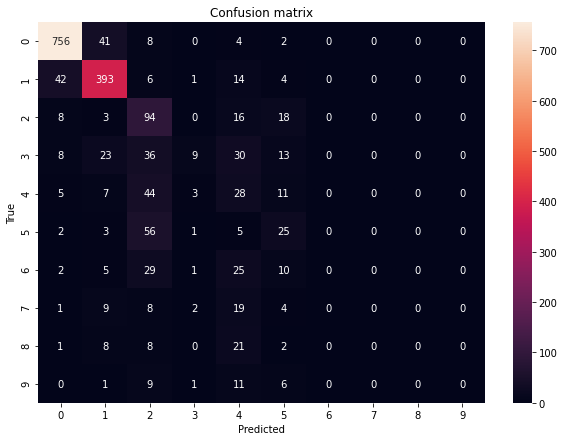

In [34]:
y_pred = tf.math.argmax(y_pred_probs, 1)
y_pred = tf.reshape(y_pred, y_pred.shape[0])

labels = tf.unique(y_true)[0].numpy()
labels.sort()

matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(matrix, index = labels,
                  columns = [i for i in labels])

plt.figure(figsize = (10,7))
plt.title("Confusion matrix")
sns.heatmap(df_cm, annot=True, fmt='g')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()